In [1]:
!git clone https://github.com/sujitojha1/ERA1.git

Cloning into 'ERA1'...
remote: Enumerating objects: 878, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 878 (delta 242), reused 263 (delta 203), pack-reused 573
Receiving objects: 100% (878/878), 59.57 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (484/484), done.


In [2]:
import os
os.chdir("/kaggle/working/ERA1/Session13/")
!pwd

/kaggle/working/ERA1/Session13


In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
configs = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]


class CNNBlock(pl.LightningModule):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(pl.LightningModule):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x


class ScalePrediction(pl.LightningModule):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )


class YOLOv3(pl.LightningModule):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in configs:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers


if __name__ == "__main__":
    num_classes = 20
    IMAGE_SIZE = 416
    model = YOLOv3(num_classes=num_classes)
    x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
    out = model(x)
    assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
    assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
    assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
    print("Success!")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Success!


In [4]:
import numpy as np
import os
import pandas as pd
import torch
from utils import xywhn2xyxy, xyxy2xywhn
import random 

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import (
    cells_to_bboxes,
    iou_width_height as iou,
    non_max_suppression as nms,
    plot_image
)

ImageFile.LOAD_TRUNCATED_IMAGES = True

class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/"
        self.label_dir = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/"
        self.image_size = image_size
        self.mosaic_border = [image_size // 2, image_size // 2]
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)
    
    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4 = []
        s = self.image_size
        yc, xc = (int(random.uniform(x, 2 * s - x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(range(len(self)), k=3)  # 3 additional image indices
        random.shuffle(indices)
        for i, index in enumerate(indices):
            # Load image
            label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
            bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
            img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
            img = np.array(Image.open(img_path).convert("RGB"))
            

            h, w = img.shape[0], img.shape[1]
            labels = np.array(bboxes)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            if labels.size:
                labels[:, :-1] = xywhn2xyxy(labels[:, :-1], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            labels4.append(labels)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, :-1],):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate
        labels4[:, :-1] = xyxy2xywhn(labels4[:, :-1], 2 * s, 2 * s)
        labels4[:, :-1] = np.clip(labels4[:, :-1], 0, 1)
        labels4 = labels4[labels4[:, 2] > 0]
        labels4 = labels4[labels4[:, 3] > 0]
        return img4, labels4 

    def __getitem__(self, index):

        image, bboxes = self.load_mosaic(index)

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)


def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


# if __name__ == "__main__":
#     test()

In [5]:
def get_loadings(train_csv_path, test_csv_path):
    from dataset import YOLODataset

    IMAGE_SIZE = config.IMAGE_SIZE
    train_dataset = YOLODataset(
        train_csv_path,
        transform=config.train_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
        label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
        anchors=config.ANCHORS,
    )
    test_dataset = YOLODataset(
        test_csv_path,
        transform=config.test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
        label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
        anchors=config.ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    train_eval_dataset = YOLODataset(
        train_csv_path,
        transform=config.test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    train_eval_loader = DataLoader(
        dataset=train_eval_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    return train_loader, test_loader, train_eval_loader

Training: 0it [00:00, ?it/s]

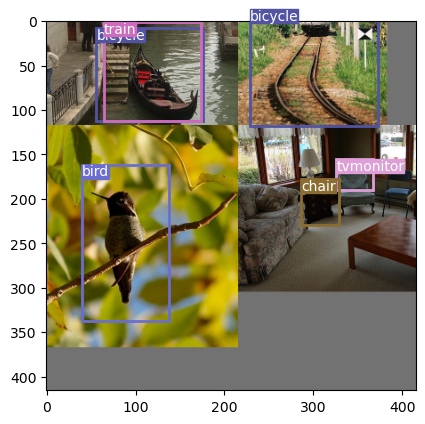

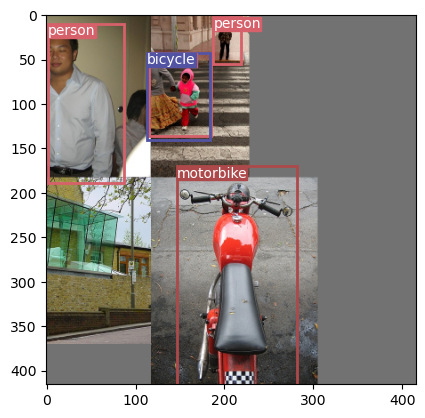

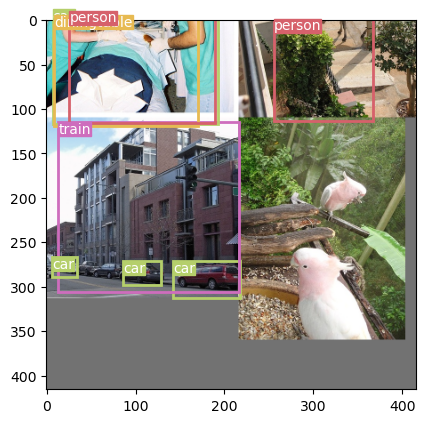

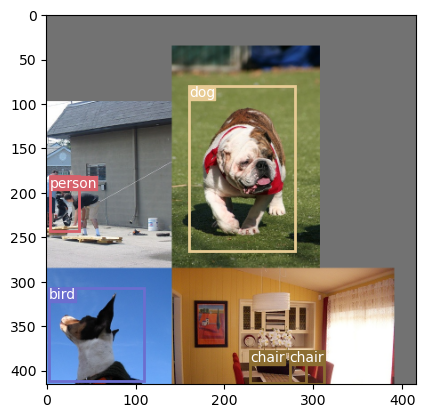

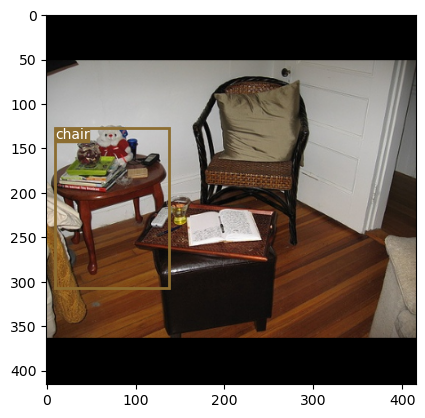

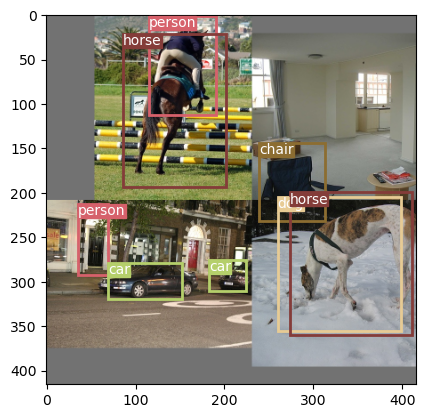

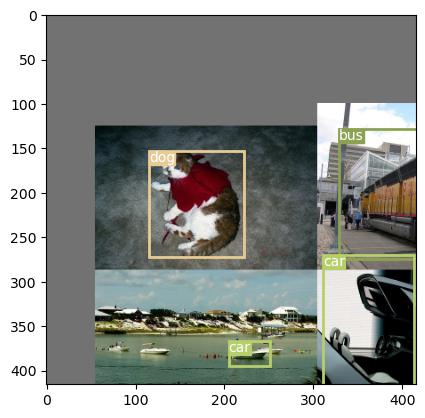

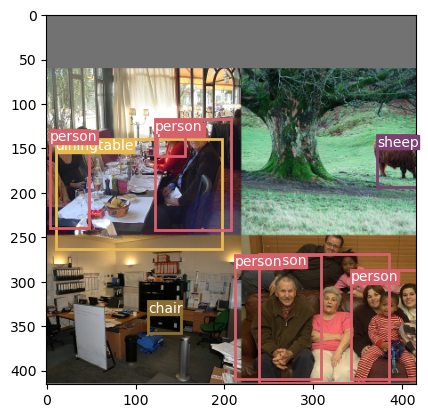

Class accuracy is: 66.972038%
No obj accuracy is: 97.798019%
Obj accuracy is: 58.063419%


100%|██████████| 155/155 [24:44<00:00,  9.58s/it]


MAP: 0.23791149258613586


In [6]:
"""
Main file for training Yolo model on Pascal VOC and COCO dataset
"""

import pytorch_lightning as pl
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    plot_couple_examples
)

from torch.cuda.amp import autocast, GradScaler
from loss import YoloLoss
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True

class YOLOv3_Arch(pl.LightningModule):
    def __init__(self,scaled_anchors):
        super().__init__()
        self.loss_fn = YoloLoss()
        self.scaler = torch.cuda.amp.GradScaler()
        self.scaled_anchors = scaled_anchors
        self.model = YOLOv3()
        
    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(),lr=config.LEARNING_RATE,
                               weight_decay=config.WEIGHT_DECAY)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                            steps_per_epoch=len(self.train_dataloader()),
                                                            epochs=20,pct_start=5/20,div_factor=100,
                                                             three_phase=False,final_div_factor=100,
                                                             anneal_strategy='linear'),
  
            'monitor': 'val_loss'
        }
        return [optimizer],[lr_scheduler]

    def training_step(self,batch,batch_idx):# scaler, scaled_anchors):
        x,y = batch
        y0,y1,y2 = y
        with autocast():
            out = self.model(x)
            loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0])
                + self.loss_fn(out[1], y1, self.scaled_anchors[1])
                + self.loss_fn(out[2], y2, self.scaled_anchors[2])
            )

        self.log('train_loss',loss,prog_bar=True,sync_dist=True)
        return loss
    

    def on_train_end(self):
        
        plot_couple_examples(self.model, self.test_dataloader(), 0.6, 0.5, self.scaled_anchors)
        check_class_accuracy(self.model, self.train_dataloader(), threshold=config.CONF_THRESHOLD)
        
        pred_boxes, true_boxes = get_evaluation_bboxes(
            self.test_dataloader(),
            self.model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        
        print(f"MAP: {mapval.item()}")

    def train_dataloader(self):
        train_path = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv"
        test_path = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv"
        trainloader = get_loadings(train_csv_path=train_path,test_csv_path=test_path)[0]
        return trainloader

    def val_dataloader(self):
        train_path = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv"
        test_path = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv"
        valloader = get_loadings(train_csv_path=train_path,test_csv_path=test_path)
        return valloader[2]

    def test_dataloader(self):
        train_path = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv"
        test_path = "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv"
        testloader = get_loadings(train_csv_path=train_path,test_csv_path=test_path)
        return testloader[1]


scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to("cuda")   

yolo_model = YOLOv3_Arch(scaled_anchors)

checkpoint_callback = ModelCheckpoint(dirpath='checkpoints/',filename='best_weights',monitor='val_loss',save_top_k=1)

trainer = Trainer(
    max_epochs=40,
    accelerator="gpu",
    devices=1,  # limiting got iPython runs
    callbacks=[checkpoint_callback],
)
trainer.fit(yolo_model)

In [7]:
# https://saturncloud.io/blog/pytorch-lightning-print-accuracy-and-loss-at-the-end-of-each-epoch//

In [9]:
torch.save(yolo_model.state_dict(), "/kaggle/working/yolov3.pt")